In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import mapply
mapply.init(n_workers=7, progressbar=True)

# Read in the data
final = pd.read_csv('../dataset/data/final_clean4.csv')

# final['isArrested'] = (final['n_arrested'] > 0)
# final['isInjured'] = (final['n_injured'] > 0)
# final['isUnharmed'] = (final['n_unharmed'] > 0)
final = final[final['OUTLIER'] == 0]

final['isKilled'] = (final['n_killed'] > 0)
final['isInjured'] = (final['n_injured'] > 0)
final['isUnharmed'] = (final['n_unharmed'] > 0)
final['isArrested'] = (final['n_arrested'] > 0)

value_counts = final['isKilled'].value_counts()
min_vc = value_counts.min()

final = final.groupby('isKilled').apply(lambda x: x.sample(min_vc)).reset_index(drop=True)


In [28]:
augmented = final.copy()

from sklearn.model_selection import train_test_split

train, test = train_test_split(augmented, test_size=0.1)

train: pd.DataFrame = train

idx_train = train.index
idx_test = test.index




train['state_year_p_isKilled'] = train.groupby(['state', 'date_year', 'date_month'])['isKilled'].transform('mean')
train['state_year_p_isArrested'] = train.groupby(['state', 'date_year', 'date_month'])['isArrested'].transform('mean')
train['state_year_p_isInjured'] = train.groupby(['state', 'date_year', 'date_month'])['isInjured'].transform('mean')
train['state_year_p_isUnharmed'] = train.groupby(['state', 'date_year', 'date_month'])['isUnharmed'].transform('mean')

# print([x for x in train[['state', 'date_year', 'state_year_p_isKilled']].drop_duplicates().values])

state_year_p_isKilled = {(x[0], x[1], x[2]): (x[3], x[4], x[5], x[6]) for x in train[['state', 'date_year', 'date_month', 'state_year_p_isKilled', 'state_year_p_isArrested', 'state_year_p_isInjured', 'state_year_p_isUnharmed']].drop_duplicates().values}
def state_year_p_isKilled_lookup(state, year, month, idx):
    try:
        return state_year_p_isKilled[(state, year, month)][idx]
    except:
        return 0.5

test['state_year_p_isKilled'] = test.apply(lambda x: state_year_p_isKilled_lookup(x['state'], x['date_year'], x['date_month'], 0), axis=1)
test['state_year_p_isArrested'] = test.apply(lambda x: state_year_p_isKilled_lookup(x['state'], x['date_year'], x['date_month'], 1), axis=1)
test['state_year_p_isInjured'] = test.apply(lambda x: state_year_p_isKilled_lookup(x['state'], x['date_year'], x['date_month'], 2), axis=1)
test['state_year_p_isUnharmed'] = test.apply(lambda x: state_year_p_isKilled_lookup(x['state'], x['date_year'], x['date_month'], 3), axis=1)

# augmented.loc[idx_train, 'state_year_p_isKilled'] = train['state_year_p_isKilled']
augmented.loc[idx_train, 'state_year_p_isArrested'] = train['state_year_p_isArrested']
augmented.loc[idx_train, 'state_year_p_isInjured'] = train['state_year_p_isInjured']
augmented.loc[idx_train, 'state_year_p_isUnharmed'] = train['state_year_p_isUnharmed']
# augmented.loc[idx_test, 'state_year_p_isKilled'] = test['state_year_p_isKilled']
augmented.loc[idx_test, 'state_year_p_isArrested'] = test['state_year_p_isArrested']
augmented.loc[idx_test, 'state_year_p_isInjured'] = test['state_year_p_isInjured']
augmented.loc[idx_test, 'state_year_p_isUnharmed'] = test['state_year_p_isUnharmed']

# del augmented['state_year_p_isArrested']
# del augmented['state_year_p_isInjured']
# del augmented['state_year_p_isUnharmed']



# test['state_year_p_isKilled'] = test.groupby(['state', 'date_year']).apply(lambda x: 
#                                     train[
#                                         (train['state'] == x['state'].iloc[0]) & 
#                                         (train['date_year'] == x['date_year'].iloc[0])
#                                     ].iloc[0]['state_year_p_isKilled']
#                                 )

In [29]:
discretized = augmented.copy()

# discretized = discretized[(discretized['OUTLIER'] == 0)]
# discretized = discretized[(discretized['CLEAN'] == 1) & (discretized['OUTLIER'] == 0)]

# discretized['state_congressional_district'] = discretized['state'].astype(str) + '_' + discretized['congressional_district'].astype(str)

TO_DISCRETIZE = ['state', 'congressional_district', 'party']

cat_cols = final.select_dtypes(include=['object']).columns
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

def one_hot(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        vars = sorted(dataset[variable].unique())
        
        for var in vars:
            dataset[variable+'_'+str(var)] = (dataset[variable] == var).astype(int)
    return dataset

# discretized = one_hot(discretized, TO_DISCRETIZE)
# discretized = discretize_data(discretized, cat_cols)
discretized = discretized.drop(columns=cat_cols)

discretized.shape

# final = final.drop(columns=cat_cols)

(90378, 83)

In [43]:
f = discretized.copy()

isKilled = f['isKilled']

del f['isKilled']
del f['isInjured']
del f['isUnharmed']
del f['isArrested']

# keywords = ['killed', 'incident_', 'p_injured', 'p_arrested', 'p_unharmed']
keywords = ['killed', 'arrested', 'unharmed', 'injured', 'DEAD', 'CLEAN', 'OUTLIER', 'incident_', 'cd_', 'state_']
whitelist = []
blacklist = ['killed']
# del all columns with keywords in it
deleted = []
for col in f.columns:
    if any([b in col for b in blacklist]):
        deleted.append(col)
        del f[col]
    elif any([w in col for w in keywords]) and not any([w in col for w in whitelist]):
        deleted.append(col)
        del f[col]

print(deleted)

# f = f[['povertyPercentage', 'date_year']]


f = f.astype('float64')


# del f['n_killed']
# del f['p_killed']
# del f['month_cd_ratio_killed']


['n_killed', 'n_injured', 'n_arrested', 'n_unharmed', 'CLEAN', 'state_population', 'OUTLIER', 'p_killed', 'p_injured', 'p_arrested', 'p_unharmed', 'month_cd_change_min_age_participants', 'month_cd_change_avg_age_participants', 'month_cd_change_max_age_participants', 'year_state_change_min_age_participants', 'year_state_change_avg_age_participants', 'year_state_change_max_age_participants', 'month_cd_ratio_males', 'month_cd_ratio_females', 'month_cd_ratio_participants_child', 'month_cd_ratio_participants_teen', 'month_cd_ratio_participants_adult', 'month_cd_ratio_killed', 'month_cd_ratio_injured', 'month_cd_ratio_arrested', 'month_cd_ratio_unharmed', 'year_state_ratio_males', 'year_state_ratio_females', 'year_state_ratio_participants_child', 'year_state_ratio_participants_teen', 'year_state_ratio_participants_adult', 'year_state_ratio_killed', 'year_state_ratio_injured', 'year_state_ratio_arrested', 'year_state_ratio_unharmed', 'month_cd_incidents', 'month_cd_votes_incidents', 'year_sta

In [44]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Scale the data
scaled = scaler.fit_transform(f)

# Convert to a dataframe
scaled = pd.DataFrame(scaled, columns=f.columns)


scaled = f

In [45]:
X_train = scaled.loc[idx_train]
X_test = scaled.loc[idx_test]

y_train = isKilled.loc[idx_train]
y_test = isKilled.loc[idx_test]

In [53]:
# calculate the importance of each feature wrt the target variable
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

clf = ExtraTreesClassifier(n_estimators=100)
clf = clf.fit(X_train, y_train)
clf.feature_importances_
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X_train)
X_new.shape

# get the selected features
selected_features = scaled.columns[model.get_support()]
selected_features


/home/simone/Unipi/InProgress/DM/DataMining-2023/.env/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Index(['date_month', 'congressional_district', 'date_day', 'latitude',
       'longitude', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'timestamp', 'povertyPercentage',
       'candidatevotes', 'totalvotes', 'percentage_republican',
       'percentage_democrat'],
      dtype='object')

In [55]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]

0.5692402262109663
0.5685992476211551
[[22017 18639]
 [16399 24285]]
[[2460 2073]
 [1826 2679]]
              precision    recall  f1-score   support

           0       0.57      0.54      0.56      4533
           1       0.56      0.59      0.58      4505

    accuracy                           0.57      9038
   macro avg       0.57      0.57      0.57      9038
weighted avg       0.57      0.57      0.57      9038



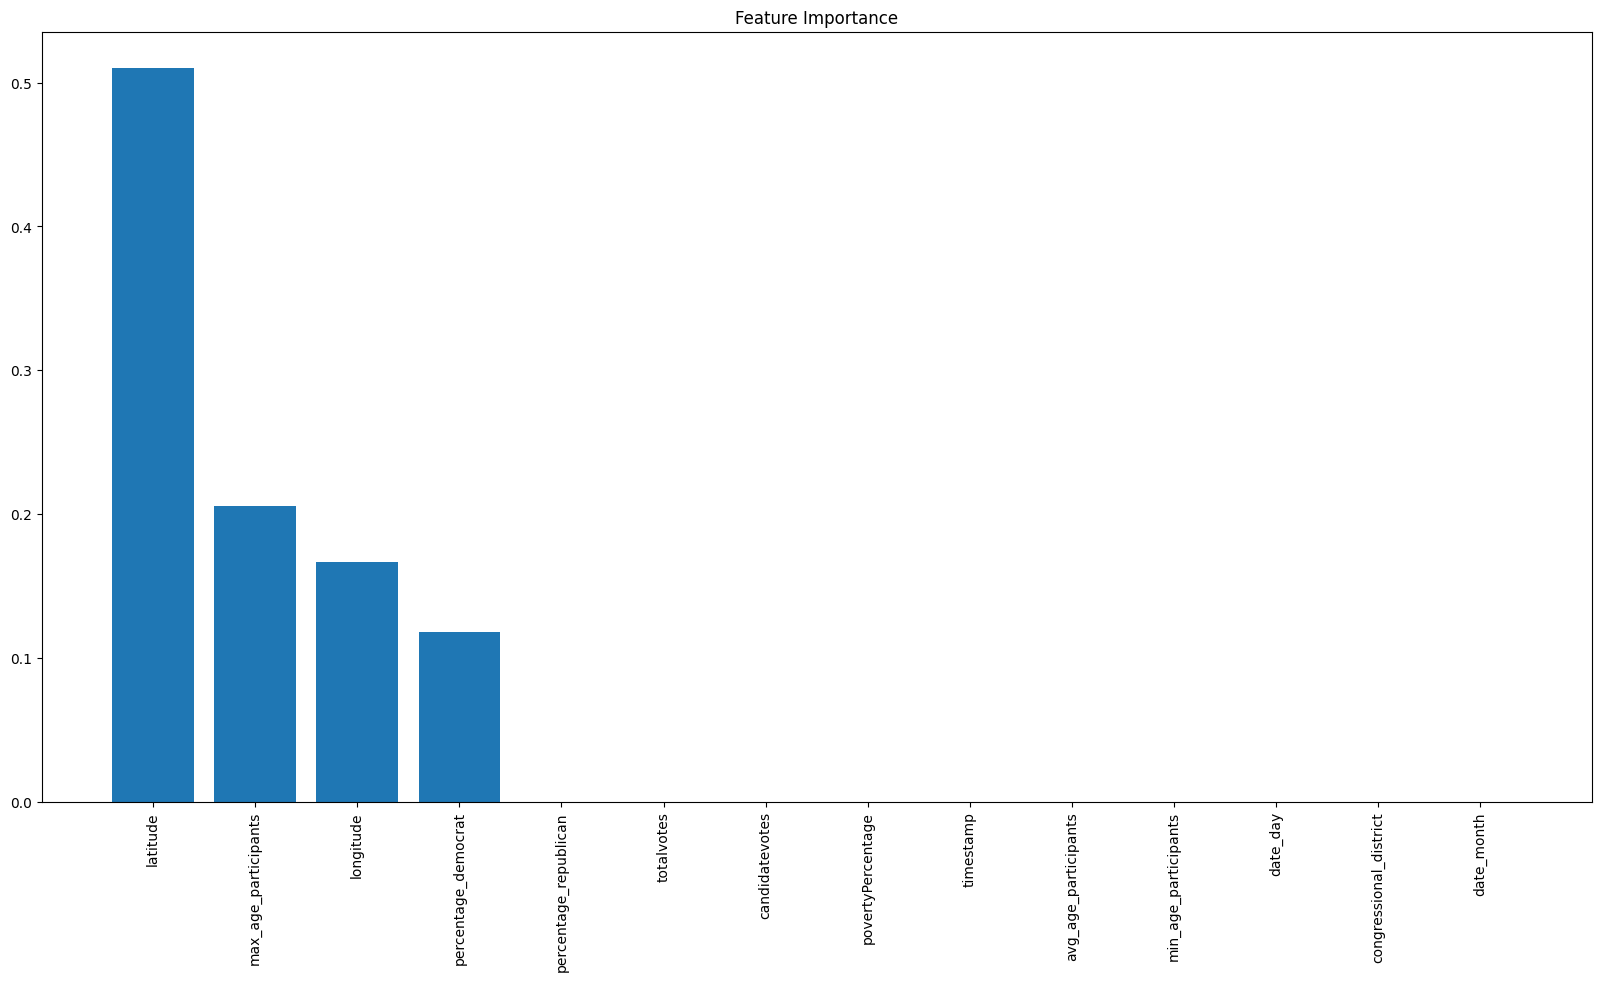

In [61]:


from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

clf = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=3, min_samples_split=3, min_samples_leaf=4)
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_test, y_pred))
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_train, y_pred_train, labels=[0, 1]))
print(confusion_matrix(y_test, y_pred, labels=[0, 1]))

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, labels=[0, 1]))

from matplotlib import pyplot as plt

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
names = [X_train.columns[i] for i in indices]

plt.figure(figsize=(20, 10))
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), names, rotation=90)
plt.show()


In [62]:
from sklearn.tree import export_graphviz

import pydotplus

# from IPython.display import Image
dot_data = export_graphviz(clf, out_file=None, feature_names=X_train.columns, class_names=['Not_Killed', 'Killed'], filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)

graph.write_png('graph.png')

True

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=7, min_samples_split=3, min_samples_leaf=4)
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_test, y_pred))

print(confusion_matrix(y_train, y_pred_train, labels=[0, 1]))
print(confusion_matrix(y_test, y_pred, labels=[0, 1]))


0.6148143594787312
0.6032308032750608
[[24038 16618]
 [14713 25971]]
[[2611 1922]
 [1664 2841]]


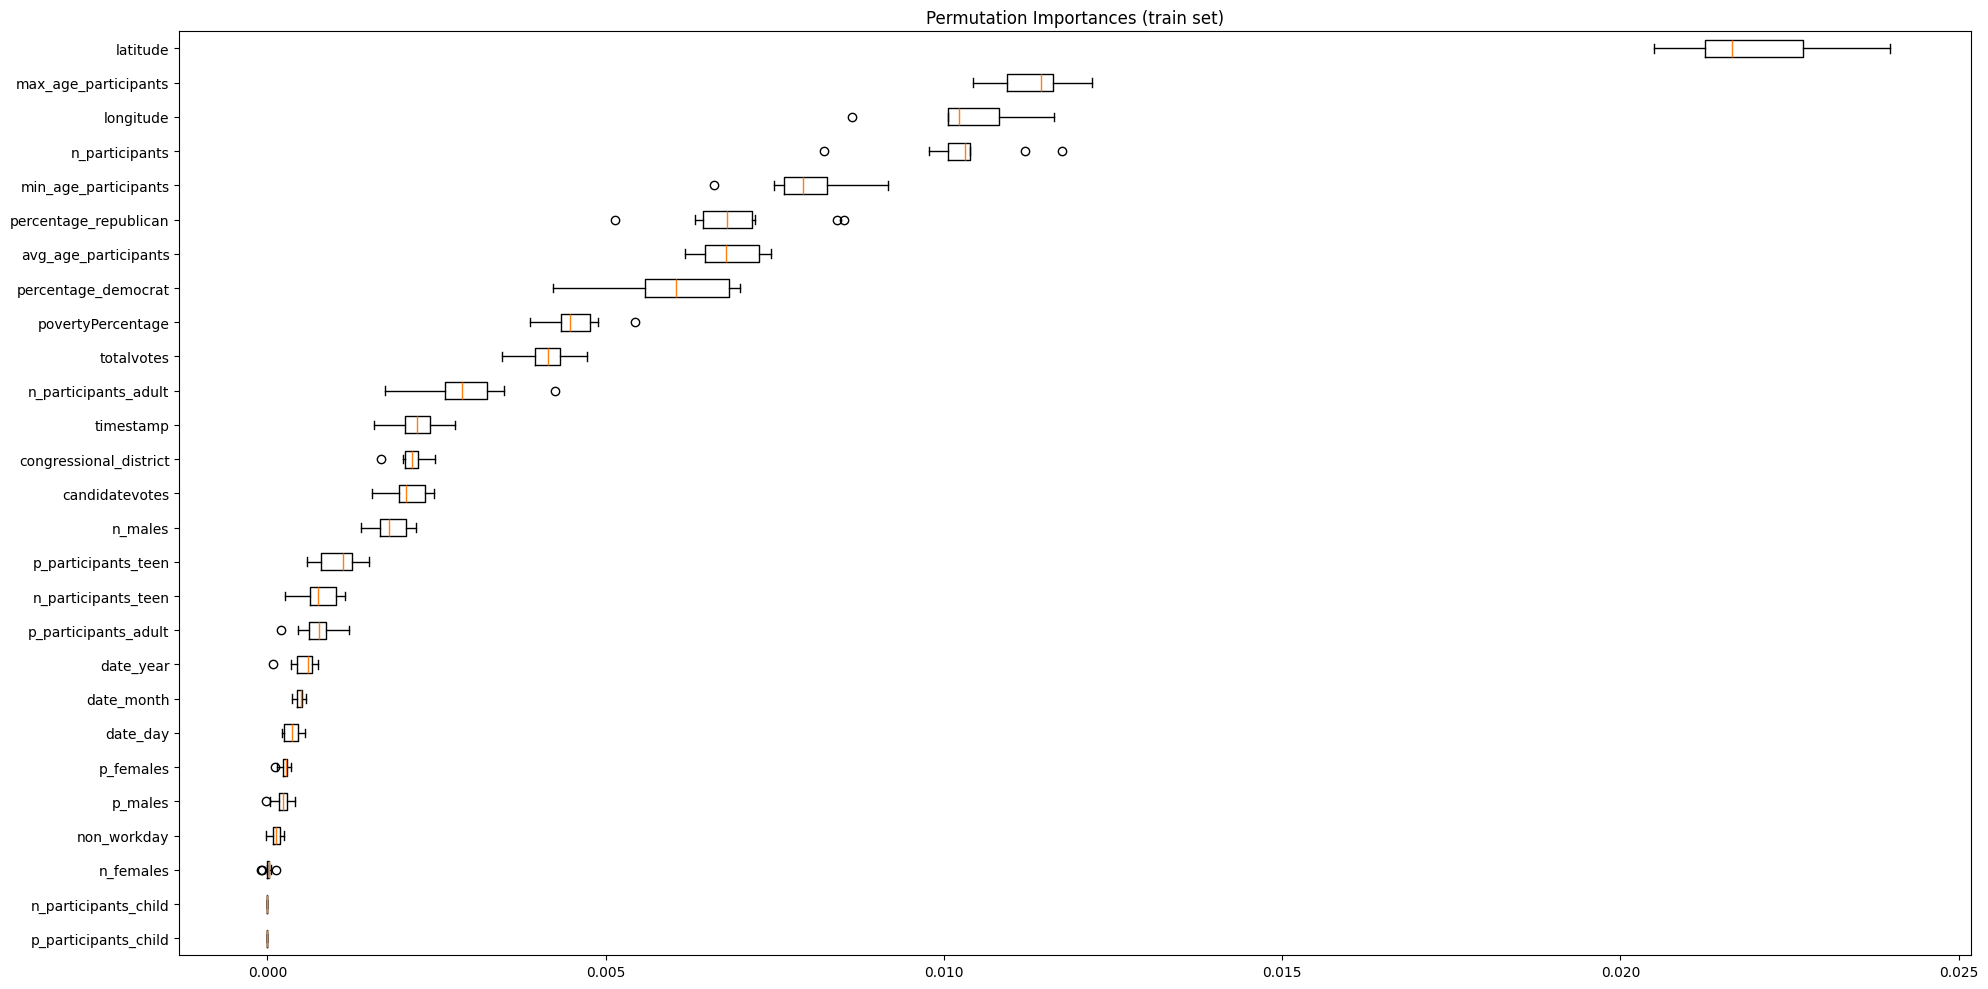

In [35]:
# random forest explanation

from sklearn.inspection import permutation_importance

result = permutation_importance(clf, X_train, y_train, n_repeats=10, random_state=42, n_jobs=7)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(20, 10))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_train.columns[sorted_idx])

ax.set_title("Permutation Importances (train set)")
fig.tight_layout()

plt.show()



Epoch 1/50000, Loss: 0.2705, Accuracy: 0.5000, Test Accuracy: 0.5000
Epoch 101/50000, Loss: 0.2521, Accuracy: 0.5000, Test Accuracy: 0.5000
Epoch 201/50000, Loss: 0.2499, Accuracy: 0.5000, Test Accuracy: 0.5000
Epoch 301/50000, Loss: 0.2496, Accuracy: 0.6216, Test Accuracy: 0.6039
Epoch 401/50000, Loss: 0.2490, Accuracy: 0.6301, Test Accuracy: 0.6074
Epoch 501/50000, Loss: 0.2473, Accuracy: 0.6429, Test Accuracy: 0.6135
Epoch 601/50000, Loss: 0.2427, Accuracy: 0.6537, Test Accuracy: 0.6163
Epoch 701/50000, Loss: 0.2331, Accuracy: 0.6650, Test Accuracy: 0.6209
Epoch 801/50000, Loss: 0.2218, Accuracy: 0.6755, Test Accuracy: 0.6273
Epoch 901/50000, Loss: 0.2133, Accuracy: 0.6850, Test Accuracy: 0.6307
Epoch 1001/50000, Loss: 0.2084, Accuracy: 0.6889, Test Accuracy: 0.6298
Epoch 1101/50000, Loss: 0.2062, Accuracy: 0.6917, Test Accuracy: 0.6285
Epoch 1201/50000, Loss: 0.2051, Accuracy: 0.6924, Test Accuracy: 0.6283
Epoch 1301/50000, Loss: 0.2046, Accuracy: 0.6937, Test Accuracy: 0.6283
Epoc

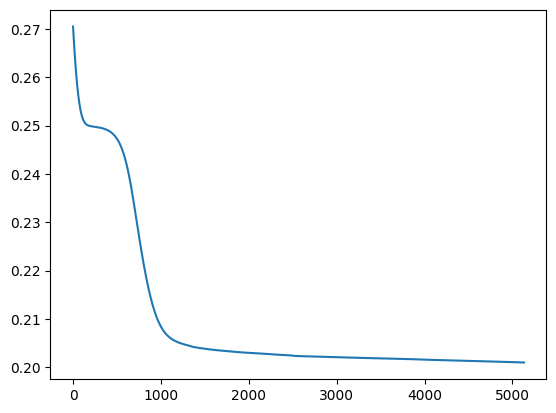

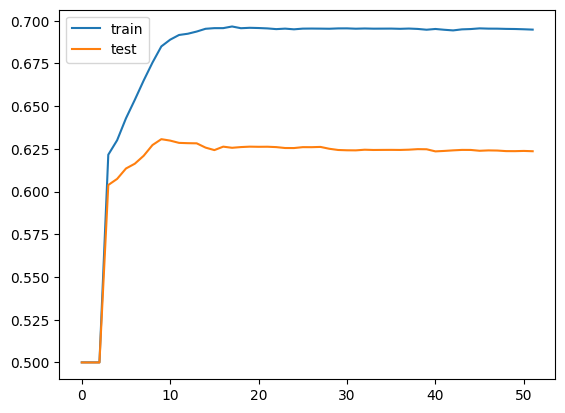

In [103]:
import torch
import torch.nn as nn

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(DEVICE)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(DEVICE)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(DEVICE)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(DEVICE)

input_size = X_train_tensor.shape[1]
hidden_size = 5
output_size = 1

loss_function = nn.MSELoss()

learning_rate = 0.001

model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.Sigmoid(),
    nn.Linear(hidden_size, hidden_size),
    nn.Sigmoid(),
    nn.Linear(hidden_size, hidden_size),
    nn.Sigmoid(),
    nn.Linear(hidden_size, hidden_size),
    nn.Sigmoid(),
    nn.Linear(hidden_size, output_size),
    nn.Sigmoid()
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

EPOCHS = 50000
losses = []
epochs = []
accs = []
accs_test = []

model.train()
for epoch in range(EPOCHS):
    try:
        optimizer.zero_grad()
        y_pred = model(X_train_tensor)
        y_pred = y_pred.squeeze(1)
        loss = loss_function(y_pred, y_train_tensor)
        losses.append(loss.item())
        if epoch % 100 == 0:
            acc = accuracy_score(y_train_tensor.detach().cpu().numpy(), np.where(y_pred.detach().cpu() > 0.5, 1, 0))
            accs.append(acc)
            y_pred_test = model(X_test_tensor)
            y_pred_test = y_pred_test.squeeze(1)
            acc_test = accuracy_score(y_test_tensor.detach().cpu().numpy(), np.where(y_pred_test.detach().cpu() > 0.5, 1, 0))
            accs_test.append(acc_test)
            print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.4f}, Accuracy: {acc:.4f}, Test Accuracy: {acc_test:.4f}')
        loss.backward()
        optimizer.step()
    except KeyboardInterrupt:
        break

from sklearn.metrics import confusion_matrix

# Convert the test data to PyTorch tensors and get the predicted class
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(DEVICE)
y_pred_tensor = model(X_test_tensor).detach().cpu()

y_pred = np.where(y_pred_tensor > 0.5, 1, 0)

# _, y_pred = torch.max(y_pred_tensor, 1)

# # Print the confusion matrix
print(confusion_matrix(y_test, y_pred))

# # Print the accuracy
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

# plot the loss over the entire training procedure
plt.plot(losses)
plt.show()

plt.plot(accs, label='train')
plt.plot(accs_test, label='test')
plt.legend()
plt.show()


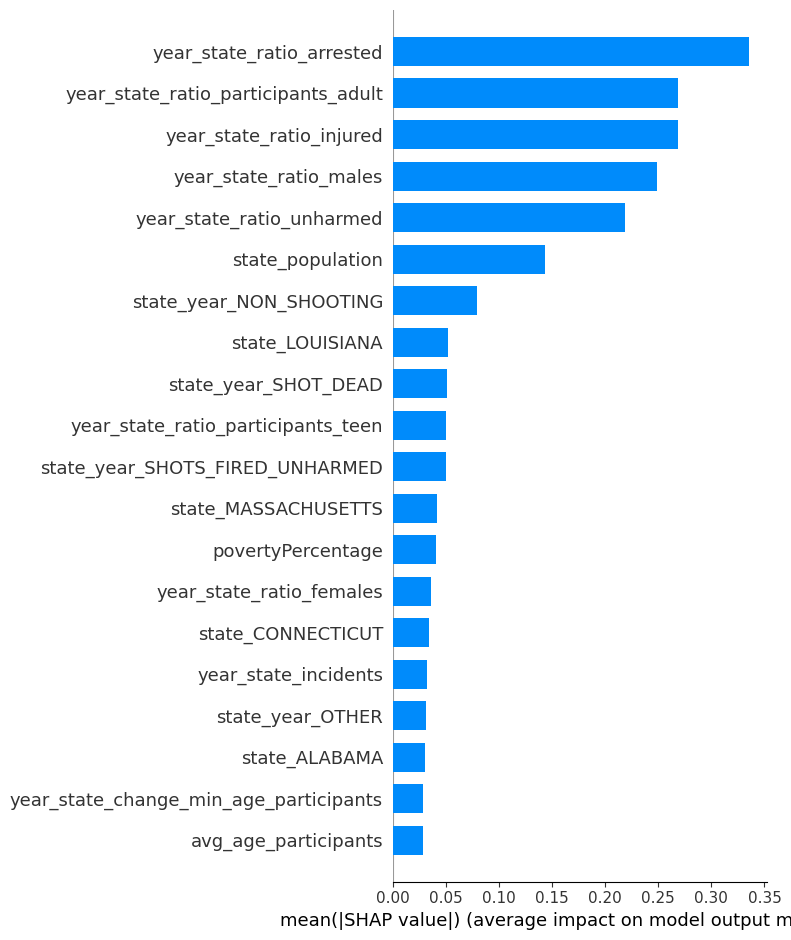

In [93]:
import shap

X_test_sample = X_test.sample(10)
X_test_sample_tensor = torch.tensor(X_test_sample.values, dtype=torch.float32).to(DEVICE)

e = shap.DeepExplainer(model, X_train_tensor)
shap_values = e.shap_values(X_test_sample_tensor)

shap.summary_plot(shap_values, X_test_tensor, feature_names=X_test.columns, plot_type="bar")